In [2]:
import pandas as pd
import numpy as np

In [38]:
data = pd.read_csv('../data/survival_clean.csv', index_col = 0)
data.head(4)

,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time_death,time_recc,target
id,,,,,,,,,,,,,,,
1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,968,1
2,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,0,0
3,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963,542,1
4,Lev+5FU,0,66,1,0,0,6.0,1,2.0,3,1,1,293,245,1


In [39]:
data.groupby(['rx']).agg(['count'])

,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time_death,time_recc,target
,count,count,count,count,count,count,count,count,count,count,count,count,count,count
rx,,,,,,,,,,,,,,
Lev,338,338,338,338,338,332,338,327,338,338,338,338,338,338
Lev+5FU,324,324,324,324,324,315,324,318,324,324,324,324,324,324
Obs,344,344,344,344,344,340,344,337,344,344,344,344,344,344


In [40]:
treatmentVariable = "rx"
targetVariable = "target"

In [ ]:
data['treatment'] = np.where(data['rx']=='Obs', 0, np.where(data['rx']=='Lev',1,2))

## Spróbujmy najpierw zaprognozować zmienną 'target' na podstawie wszystkich zmiennych - zwykłe drzewo

Zamieniam zmienną 'rx' na zmienną kategoryczną, 'Obs' = 0, 'Lev'=1, 'Lev+FU'=2

In [80]:
df = data.drop(['rx', 'time_recc','time_death'], axis=1)

In [81]:
df.isna().sum()

sex           0
age           0
obstruct      0
perfor        0
adhere        0
nodes        19
status        0
differ       24
extent        0
surg          0
node4         0
target        0
treatment     0
dtype: int64

missingi w 'nodes' zamieniam na 0, gdyż mozemy uznac, że jak nie mamy danych to tych węzłów chłonnych było 0

missingi w 'differ' zamieniam na -1, gdyż nie wiemy jak bardzo komórki były zróżnicowane

In [92]:
df.differ = df.differ.fillna(-1)
df.nodes = df.nodes.fillna(0)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target',axis=1), df.target, random_state = 123)

## Extra_trees

In [96]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=100, max_depth=3, random_state=123, oob_score=True, bootstrap=True)
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=3, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=True, random_state=123, verbose=0,
                     warm_start=False)

In [97]:
from sklearn.metrics import roc_auc_score

print(f'Test -> AUC = {round(roc_auc_score(y_test, clf.predict(X_test))*100,2)}%')
print(f'Train -> AUC = {round(roc_auc_score(y_train, clf.predict(X_train))*100,2)}%')

Test -> AUC = 90.98%
Train -> AUC = 90.31%


In [98]:
pd.DataFrame({'columns': X_train.columns, 'importance': clf.feature_importances_}).sort_values('importance', ascending = False)

,columns,importance
6,status,0.747059
10,node4,0.101439
11,treatment,0.026713
8,extent,0.024557
4,adhere,0.022921
5,nodes,0.022467
1,age,0.018148
3,perfor,0.010347
2,obstruct,0.007869
0,sex,0.007074


## XGBoost - bo radzi sobie z nan

In [99]:
df = data.drop(['rx', 'time_recc','time_death'], axis=1)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target',axis=1), df.target, random_state = 123)

In [101]:
from xgboost import XGBClassifier

In [118]:
clf = XGBClassifier(n_estimators = 120, max_depth = 3, random_state=123)

In [119]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [120]:
print(f'Test -> AUC = {round(roc_auc_score(y_test, clf.predict(X_test))*100,2)}%')
print(f'Train -> AUC = {round(roc_auc_score(y_train, clf.predict(X_train))*100,2)}%')

Test -> AUC = 87.55%
Train -> AUC = 94.4%


In [121]:
pd.DataFrame({'columns': X_train.columns, 'importance': clf.feature_importances_}).sort_values('importance', ascending = False)

,columns,importance
6,status,0.761805
9,surg,0.028714
4,adhere,0.028180
2,obstruct,0.027135
11,treatment,0.025235
0,sex,0.022726
5,nodes,0.021278
1,age,0.021252
8,extent,0.018232
10,node4,0.017882


## Casualml

Wyciągamy podpróbkę Levamisole + Observation

In [125]:
data.head()

,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time_death,time_recc,target,treatment
id,,,,,,,,,,,,,,,,
1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,968,1,2
2,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,0,0,2
3,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963,542,1,0
4,Lev+5FU,0,66,1,0,0,6.0,1,2.0,3,1,1,293,245,1,2
5,Obs,1,69,0,0,0,22.0,1,2.0,3,1,1,659,523,1,0


In [142]:
df =  data[data['rx'].isin(['Lev','Obs'])].drop('treatment', axis=1)

In [143]:
df.shape

(682, 15)

In [145]:
df.rx.value_counts()

Obs        344
Lev        338
Lev+5FU      0
Name: rx, dtype: int64

In [146]:
X = df.drop(['rx','target'], axis=1)
y = df['target']
treatment = df['rx']

In [136]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

### Train uplift tree

In [153]:
df_train, df_test = train_test_split(df, random_state = 123)

In [154]:
X = df_train.drop(['rx','target'], axis=1)
y = df_train['target']
treatment = df_train['rx']

In [155]:
uplift_model = UpliftTreeClassifier(
    max_depth = 4, 
    min_samples_leaf = 10, 
    min_samples_treatment = 5, 
    n_reg = 100, 
    evaluationFunction='KL', 
    control_name='Obs'
)
uplift_model.fit(X.values,
                 treatment=treatment.values,
                 y=y.values)
result = uplift_tree_string(uplift_model.fitted_uplift_tree, df.columns)

sextreatment_group_key >= 43.0?
yes -> differtreatment_group_key >= 2.5?
		yes -> agetreatment_group_key >= 0.1?
				yes -> {'Obs': 0.581395, 'Lev': 0.644444}
				no  -> {'Obs': 0.628743, 'Lev': 0.549669}
		no  -> node4treatment_group_key >= 2291.5?
				yes -> {'Obs': 0.0, 'Lev': 0.0}
				no  -> {'Obs': 0.428571, 'Lev': 0.777778}
no  -> node4treatment_group_key >= 674.5999999999999?
		yes -> node4treatment_group_key >= 2180.0?
				yes -> {'Obs': 0.166667, 'Lev': 0.2}
				no  -> {'Obs': 0.6, 'Lev': 0.75}
		no  -> {'Obs': 0.875, 'Lev': 1.0}


In [158]:
X = df_test.drop(['rx','target'], axis=1)
y = df_test['target']
treatment = df_test['rx']

In [205]:
preds = uplift_model.predict(X.values)

In [184]:
pd.options.display.max_rows = 999

In [185]:
pd.DataFrame({'name': preds[0], 'preds':preds[1]}).sort_values('preds')

,name,preds
101,Obs,0.000000
118,Obs,0.000000
35,Obs,0.000000
156,Obs,0.000000
82,Obs,0.000000
8,Obs,0.000000
133,Obs,0.000000
39,Obs,0.000000
73,Obs,0.000000
141,Obs,0.000000


In [188]:
treatment.values

[Obs, Lev, Obs, Lev, Lev, ..., Lev, Obs, Obs, Lev, Lev]
Length: 171
Categories (3, object): [Lev, Lev+5FU, Obs]

In [209]:
print('Przewidywanie leczenia: ')
print(f'Acc = {round(np.sum([treatment.values[i]==preds[0][i] for i in range(len(preds[0]))])/len(treatment)*100,2)}%')
print('Przewidywanie nawrotu choroby: ')
print(f'AUC = {round(roc_auc_score(y, preds[1])*100,2)}%')

Przewidywanie leczenia: 
Acc = 43.27%
Przewidywanie nawrotu choroby: 
AUC = 55.35%


##  Uplift Random forest

In [223]:
df2 =  data.drop('treatment', axis=1)
df_train, df_test = train_test_split(df2, random_state = 123)

In [224]:
X = df_train.drop(['rx','target'], axis=1)
y = df_train['target']
treatment = df_train['rx']

In [225]:
uplift_forest = UpliftRandomForestClassifier(control_name='Obs')
uplift_forest.fit(X.values,
                 treatment=treatment.values,
                 y=y.values)


In [230]:
X = df_test.drop(['rx','target'], axis=1)
y = df_test['target']
treatment = df_test['rx']

In [231]:
y_pred = uplift_forest.predict(X.values)

In [232]:
result = pd.DataFrame(y_pred,
                      columns=uplift_forest.classes_)

In [233]:
result

,Lev,Lev+5FU
0,-0.107513,-0.165380
1,0.001821,-0.226837
2,-0.151447,-0.330670
3,0.080189,-0.038082
4,-0.067324,-0.156214
5,0.037449,-0.004867
6,-0.007240,-0.090803
7,-0.053716,-0.067673
8,-0.019788,-0.099018
9,0.061237,-0.058297


In [234]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['rx'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['rx'] == 'Obs', 1, 0)

In [235]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

In [237]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test.loc[synthetic, 'target'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_forest.classes_)))

In [239]:
from causalml.metrics import plot_gain


In [241]:
plot_gain(auuc_metrics, outcome_col='target', treatment_col='is_treated')

AssertionError: 

In [242]:
y_pred[:,0]

array([-1.075126e-01,  1.820800e-03, -1.514471e-01,  8.018860e-02,
       -6.732370e-02,  3.744930e-02, -7.239600e-03, -5.371620e-02,
       -1.978760e-02,  6.123710e-02,  4.810130e-02, -1.352730e-02,
       -2.186100e-02, -1.354440e-02, -4.038600e-02,  7.498010e-02,
       -2.078940e-02,  4.786620e-02, -6.085000e-02,  1.272090e-02,
       -9.942910e-02,  8.637500e-03, -6.734080e-02, -1.606170e-02,
       -6.734080e-02,  4.037720e-02,  5.641790e-02,  1.820800e-03,
       -8.090840e-02,  5.424200e-03, -5.093000e-02, -1.151057e-01,
        1.431232e-01, -6.203280e-02, -7.118860e-02,  8.297130e-02,
       -6.590750e-02, -1.352730e-02, -4.309200e-02, -8.501200e-03,
        1.272090e-02,  1.820800e-03, -8.090840e-02,  2.077230e-02,
       -5.091290e-02, -8.022700e-03,  4.037720e-02, -2.078940e-02,
       -8.635020e-02, -6.732370e-02, -8.635020e-02,  5.292050e-02,
        6.359690e-02,  1.080263e-01, -9.129520e-02, -1.062961e-01,
       -8.090840e-02, -5.202990e-02,  8.130200e-03,  2.991600e

In [243]:
print('Przewidywanie leczenia: ')
print(f'Acc = {round(np.sum([treatment.values[i]==y_pred[0][i] for i in range(len(y_pred[0]))])/len(treatment)*100,2)}%')
print('Przewidywanie nawrotu choroby: ')
print(f'AUC = {round(roc_auc_score(y, y_pred[1])*100,2)}%')

Przewidywanie leczenia: 
Acc = 0.0%
Przewidywanie nawrotu choroby: 


ValueError: Found input variables with inconsistent numbers of samples: [252, 2]

In [85]:
uplift_model.fit(data_to_model[new_cols].values,
                 treatment=data_to_model[treatmentVariable].values,
                 y=data_to_model[targetVariable].values)

In [86]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, data_to_model.columns)

{'Obs': 1.5, 'Lev': 1.5}


cannot convert float NaN to integer


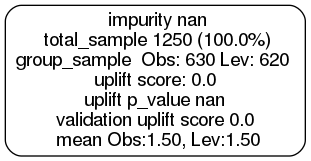

In [87]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())